In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
def load_data(file_name):
    # load from XLSX file
    dataset = pd.read_excel(io=file_name)
    
    from pandas.tseries.offsets import MonthEnd
    
    # assign last day of month
    dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
    
    # order ascending data values
    dataset = dataset.sort_values(by='Date', ascending=True)
    
    # drop unnecessary columns
    dataset = dataset.drop(['Year', 'Month'], axis=1)
    
    # set date column as index
    dataset.set_index('Date', inplace=True)
    
    # drop NaN rows
    dataset.dropna(subset=['Combined'], inplace=True)
    
    return dataset

df = load_data(file_name="montly.xlsx")
df.tail()

,Combined
Date,
2023-09-30,5.02
2023-10-31,4.87
2023-11-30,5.55
2023-12-31,5.69
2024-01-31,5.10


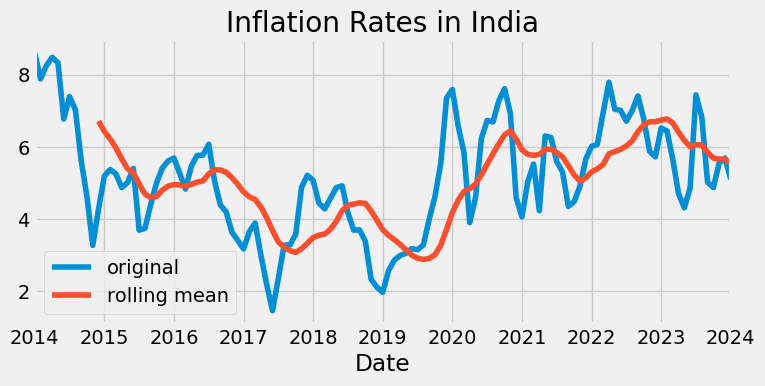

In [3]:
plt.figure(figsize=(8, 3.5))

df['Combined'].plot(label='original')
df['Combined'].rolling(window=12).mean().plot(label='rolling mean')
plt.title('Inflation Rates in India')
plt.legend()

plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

n_lags = adfuller(df['Combined'], autolag='AIC')[2]
print('Number of lags:', n_lags)

Number of lags: 12


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# reshape 1d array to 2d array - from (N,) to (N, 1)
dataset = np.reshape(df.values, (-1, 1))

# normalize dataset
norm_df = scaler.fit_transform(dataset)

print('Data shape:', norm_df.shape)

Data shape: (121, 1)


In [6]:
# supervised & target subsets
X, y = [], []

for i in range(n_lags, len(df)):
    X.append(norm_df[i - n_lags:i, 0])
    y.append(norm_df[i, 0])
    
# convert lists into arrays
X, y = np.array(X), np.array(y)

# reshape 2d array to 3d array (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y = np.reshape(y, (y.shape[0], 1))


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

# define CNN model
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X.shape[1], X.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(1))
cnn.compile(optimizer='adam', loss='mean_squared_error')

cnn_history = cnn.fit(
    x=X,
    y=y,
    epochs=200,
    batch_size=10,
    verbose=1,
    callbacks=None
)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1224
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0476 
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0304 
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250 
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272 
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305 
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271 
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207 
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0266 
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 
Epoch 13/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0215 
Epoch 14/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0185 
Epoch 15/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

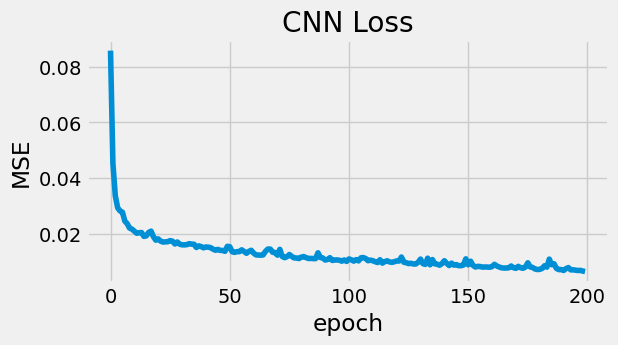

In [8]:
# plot learning process
plt.figure(figsize=(6, 3))

plt.plot(range(200), cnn_history.history['loss'])
plt.title('CNN Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')

plt.show()

In [9]:
# make predictions and rescale back from [0, 1] to original
cnn_predictions = cnn.predict(X)
cnn_pred = scaler.inverse_transform(cnn_predictions)

# true inflation rates
true = df.iloc[n_lags:]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(true, cnn_pred))
r2 = r2_score(true, cnn_pred)
mae = mean_absolute_error(true, cnn_pred)
mape = mean_absolute_percentage_error(true, cnn_pred)

print('CNN performance:')
print('----------------')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

CNN performance:
----------------
RMSE: 0.5538
R2: 0.8494
MAE: 0.3838
MAPE: 0.0812%


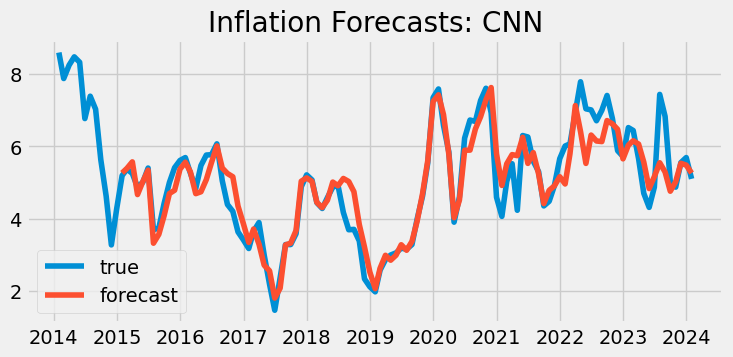

In [11]:
plt.figure(figsize=(8, 3.5))

plt.plot(df['Combined'], label='true')
plt.plot(df.iloc[n_lags:].index, cnn_pred, label='forecast')
plt.title('Inflation Forecasts: CNN')
plt.legend()

plt.show()

In [12]:

# number of time steps (months) to forecast ahead
forecast_period = 6
forecast = []
last_sequence = X[-1]

# get out-of samples
for _ in range(forecast_period):
    last_sequence = last_sequence.reshape((1, n_lags, 1)) # reshape last_sequence for prediction
    
    next_pred = cnn.predict(last_sequence) # predict the next value
    
    forecast.append(next_pred[0, 0]) # append the predicted value to list
    
    # update last_sequence with the new value
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred[0, 0]).reshape((1, n_lags, 1))

cnn_forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


LSTM

In [13]:
from keras.layers import LSTM

# define LSTM model
lstm = Sequential()
lstm.add(LSTM(units=64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
lstm.add(LSTM(units=64, return_sequences=False))
lstm.add(Dense(32))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mean_squared_error')

lstm_history = lstm.fit(
    x=X,
    y=y,
    epochs=60,
    batch_size=10,
    verbose=1,
    callbacks=None
)

Epoch 1/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1298
Epoch 2/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0390
Epoch 3/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270
Epoch 4/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0338
Epoch 5/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0305
Epoch 6/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0290
Epoch 7/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0285 
Epoch 8/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0258 
Epoch 9/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0289 
Epoch 10/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0253
Epoch 11/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0261
Epoch 12/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0254 
Epoch 13/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250
Epoch 14/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0243 
Epoch 15/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 
Epoch 16/60
1

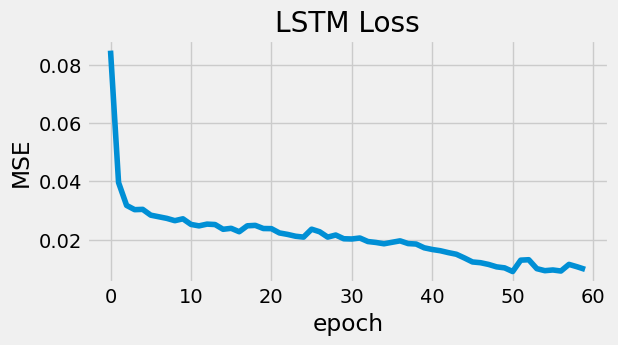

In [14]:
plt.figure(figsize=(6, 3))

plt.plot(range(60), lstm_history.history['loss'])
plt.title('LSTM Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')

plt.show()

In [15]:
# make predictions and rescale back from [0, 1] to original
lstm_predictions = lstm.predict(X)
lstm_pred = scaler.inverse_transform(lstm_predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


In [16]:
rmse = np.sqrt(mean_squared_error(true, lstm_pred))
r2 = r2_score(true, lstm_pred)
mae = mean_absolute_error(true, lstm_pred)
mape = mean_absolute_percentage_error(true, lstm_pred)

print('LSTM performance:')
print('-----------------')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

LSTM performance:
-----------------
RMSE: 0.6795
R2: 0.7732
MAE: 0.4969
MAPE: 0.1120%


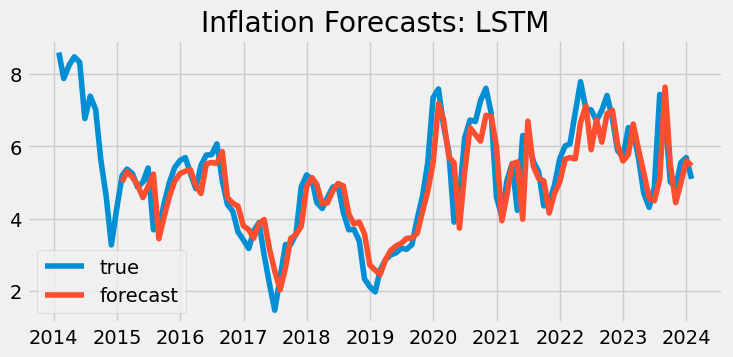

In [17]:
# plot predictions
plt.figure(figsize=(8, 3.5))

plt.plot(df['Combined'], label='true')
plt.plot(df.iloc[n_lags:].index, lstm_pred, label='forecast')
plt.title('Inflation Forecasts: LSTM')
plt.legend()

plt.show()

In [18]:
forecast = []
last_sequence = X[-1]

# get out-of samples
for _ in range(forecast_period):
    last_sequence = last_sequence.reshape((1, n_lags, 1)) # reshape last_sequence for prediction
    
    next_pred = lstm.predict(last_sequence) # predict the next value
    
    forecast.append(next_pred[0, 0]) # append the predicted value to list
    
    # update last_sequence with the new value
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred[0, 0]).reshape((1, n_lags, 1))

lstm_forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [19]:
# mm/dd/yyyy format
placeholder = pd.date_range(start='02/01/2024', end='08/01/2024', freq='M')

# new dataframe with out-of samples
df_forecasts = pd.DataFrame()
df_forecasts['date'] = placeholder
df_forecasts['cnn'] = cnn_forecast
df_forecasts['lstm'] = lstm_forecast
df_forecasts.set_index('date', inplace=True)

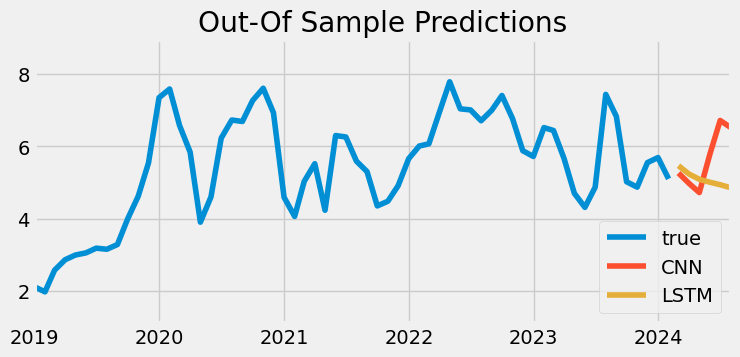

In [20]:
# plot out-of samples
plt.figure(figsize=(8, 3.5))

plt.plot(df['Combined'], label='true')
plt.plot(df_forecasts['cnn'], label='CNN')
plt.plot(df_forecasts['lstm'], label='LSTM')
plt.title('Out-Of Sample Predictions')
plt.xlim(pd.Timestamp('2019-01-01'), df_forecasts.index[-1])
plt.legend()

plt.show()

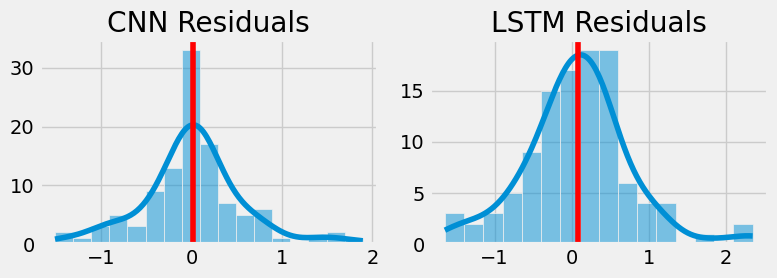

In [21]:
from seaborn import histplot

# residuals
cnn_resid = true.values - cnn_pred
lstm_resid = true.values - lstm_pred

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
histplot(x=cnn_resid.reshape(-1,), kde=True)
plt.axvline(x=cnn_resid.mean(), color='red') # plot mean value
plt.title('CNN Residuals')
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(1, 2, 2)
histplot(x=lstm_resid.reshape(-1,), kde=True)
plt.axvline(x=lstm_resid.mean(), color='red') # plot mean value
plt.title('LSTM Residuals')
plt.xlabel(None)
plt.ylabel(None)

plt.tight_layout()
plt.show()